# Performance Measurement

[Example](https://github.com/quantopian/empyrical/blob/master/empyrical/perf_attrib.py)

Performance Measurement at the level of

1. Trades
2. Strategies
3. Portfolios

***

Before we start reviewing the performance measures. Let's download some data and review the theory and practice side-by-side.

***

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pandas Datareader

[Pandas-datareader](http://pandas-datareader.readthedocs.io/en/latest/#)

In [2]:
!pip install pandas-datareader

In [3]:
import pandas_datareader.data as web
import datetime

In [4]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2013, 1, 27)

In [5]:
stock_data = web.DataReader('IBM', 'google', start, end)
print(stock_data.head())

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas_datareader/google/daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


              Open    High     Low   Close   Volume
Date                                               
2010-01-04  131.18  132.97  130.85  132.45  6155846
2010-01-05  131.68  131.85  130.10  130.85  6842471
2010-01-06  130.68  131.49  129.81  130.00  5605290
2010-01-07  129.87  130.25  128.91  129.55  5840569
2010-01-08  129.07  130.92  129.05  130.85  4197105


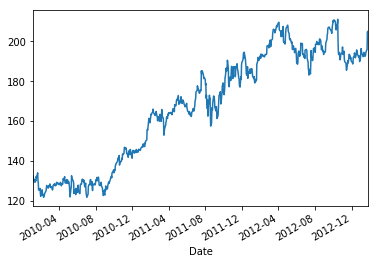

In [6]:
stock_data.Close.plot();

In [7]:
rf = web.DataReader('DTB3', 'fred', start, end)
print(rf.head())

            DTB3
DATE            
2010-01-01   NaN
2010-01-04  0.08
2010-01-05  0.07
2010-01-06  0.06
2010-01-07  0.05


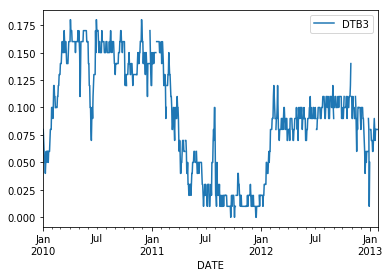

In [8]:
rf.plot();

***

## Typical Performance Measures

1. Returns
    * Total Returns
    * Compound annual growth rate (CAGR)
    
2. Risks
    * Standard deviation
    * Drawdown
    
3. Reward-to-Risk Ratio
    * Sharpe Ratio
    * Information Ratio
    * Sortino Ratio
    * CALMAR Ratio


## Declaration of Constants

In [9]:
TRADING_DAYS_PER_YEAR = 250

***

# Performance Measurement - Returns

## Price to Returns

In [10]:
def price_to_returns(price, period='daily', annualised=False):
    """
    Converts price series to (annualised) returns.
    
    250 trading days is assumed
    
    returns = (price_1 / price_0 - 1) * TRADING_DAYS_PER_YEAR
    
    Parameters
    ----------
    price : panda Series
    
    period : default daily. Other periods are not implemented
    
    annualised : default is False. An indicator to state whether you want
                 the output to be annualised returns.
    
    
    Returns
    -------
    returns : pandas Series
    """
    _annualised = 1
    
    if annualised==True:
        _annualised = TRADING_DAYS_PER_YEAR
    
    return price.pct_change() * _annualised
    

Stock Returns series

Date
2010-01-04         NaN
2010-01-05   -0.012080
2010-01-06   -0.006496
2010-01-07   -0.003462
2010-01-08    0.010035
Name: Close, dtype: float64


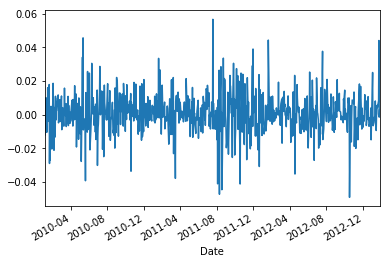

In [11]:
returns = price_to_returns(stock_data['Close'])
print(returns.head());
returns.plot();

## Annualised stock returns

Date
2010-01-04         NaN
2010-01-05   -3.020008
2010-01-06   -1.623997
2010-01-07   -0.865385
2010-01-08    2.508684
Name: Close, dtype: float64


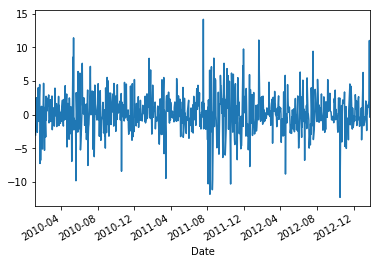

In [12]:
annualised_returns = price_to_returns(stock_data['Close'], annualised=True)
print(annualised_returns.head())
annualised_returns.plot();

Descriptive stats on annualised stock returns performance

In [13]:
annualised_returns.describe()

count    770.000000
mean       0.159835
std        3.003650
min      -12.286730
25%       -1.303811
50%        0.128766
75%        1.614019
max       14.163053
Name: Close, dtype: float64

## Cummulative Returns Series (Equity Curve)

In [14]:
def cummulative_returns(returns):
    """
    Converts returns to cummulative returns.
    
    The series will start from 1
    
    Parameters
    ----------
    returns : pandas Series
    
    Assumed default is daily returns
    
    Returns
    -------
    pandas Series of cummulative returns (non annualised)
    
    """
    
    return (returns + 1).cumprod()
    

Cummulative Returns

Date
2010-01-04         NaN
2010-01-05    0.987920
2010-01-06    0.981502
2010-01-07    0.978105
2010-01-08    0.987920
Name: Close, dtype: float64


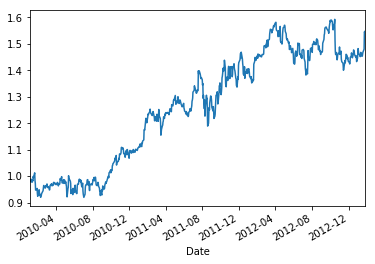

In [15]:
cum_returns = cummulative_returns(returns)
print(cum_returns.head())
cum_returns.plot();

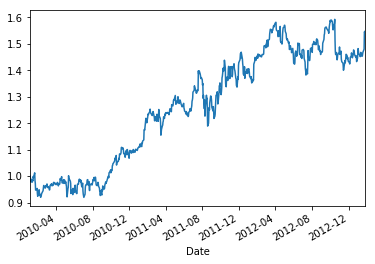

In [16]:
cum_returns[0] = 1
cum_returns.plot();

## Total Returns

In [17]:
def total_returns(returns):
    """
    Calculates the total holding period returns.
    
    Parameters
    ----------
    returns : pandas Series
    
    Assumed default is daily returns
    
    Returns
    -------
    total returns : scalar 
    
    """    
    return (returns + 1).cumprod()[-1] - 1

Total returns

In [18]:
print("The Total returns for the whole period is {:.2f}%".format(total_returns(returns) * 100))

The Total returns for the whole period is 54.75%


## Compound annual growth rate (CAGR)

$$FV=PV(1+r)^n$$
$$r=(\frac{FV}{PV})^\frac{1}{n}-1$$

In [19]:
def cagr(returns):
    """
    Calculates the Compound annual growth rate (CAGR)
    
    Parameters
    ----------
    returns : pandas Series
    
    Assumed default is daily returns
    
    Returns
    -------
    total returns : scalar 
    
    """
    return (cummulative_returns(returns)[-1] ** (1 / len(returns)) - 1) * TRADING_DAYS_PER_YEAR

CAGR

In [20]:
print("The Compound Annual Growth Rate is {:.2f}%".format(cagr(returns) * 100))

The Compound Annual Growth Rate is 14.16%


***

# Performance Measurement - Risks

## Standard Deviation (Volatility)

In [21]:
def annualised_sd(returns):
    """
    Calcuates the annualised standard deviation
    
    Parameters
    ----------
    returns : pandas series
    
    Assumed default is daily returns
    
    Returns
    -------
    Scalar
    """
    import numpy as np
    
    return returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)

Standard Deviation

In [22]:
print("The Standard Deviation is {:.2f}%".format(annualised_sd(returns) * 100))

The Standard Deviation is 19.00%


## Skewness

In [23]:
returns.skew()

-0.049206731371485526

## Kurtosis

[doc](http://pandas.pydata.org/pandas-docs/version/0.18/generated/pandas.Series.kurtosis.html)

In [24]:
returns.kurt()

2.7368395281555395

## High Watermark and Drawdown

In [25]:
def dd(returns):
    """
    Calculate the drawdown and high watermark for the entire trading period
    
    Parameters
    ----------
    returns : pandas series
    
    Assumed default is daily returns
    
    Returns
    -------
    high water mark : pandas series
    maximum drawdown : pandas series
    """
    import numpy as np
    import pandas as pd
    cum_rtn = cummulative_returns(returns)
    cum_rtn[0] = 0
    hwm = list(np.zeros(len(cum_rtn)))
    drawdown = list(np.zeros(len(cum_rtn)))
    drawdown[0] = 0
    
    for k, rtn in enumerate(cum_rtn):
        if k == 0:
            pass
        else:
            if rtn > hwm[k-1]:
                hwm[k] = rtn
            else:
                hwm[k] = hwm[k-1]
        drawdown[k] = cum_rtn[k] - hwm[k]
    return pd.Series(hwm, index=returns.index), pd.Series(drawdown, index=returns.index)
    

High Water Mark and Drawdown

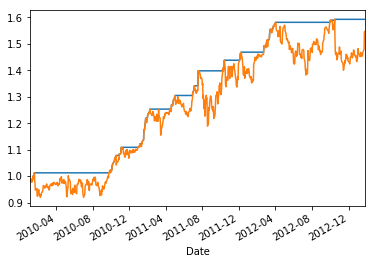

In [26]:
hwm, drawdown = dd(returns)
hwm[1:].plot();
cummulative_returns(returns)[1:].plot();

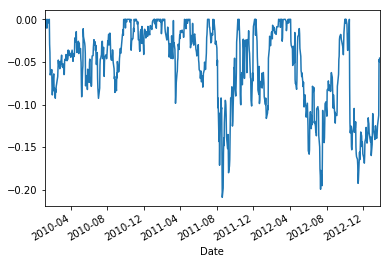

In [27]:
drawdown.plot();

## Maximum Drawdown

In [28]:
def mdd(returns):
    """
    Calculate the maximum drawdown for the entire period
    
    Parameters
    ----------
    returns : pandas series
    
    Assumed default is daily returns

    Returns
    -------
    maximum drawdown : scalar
    
    """
    
    return dd(returns)[1].min()

Maximum drawdown

In [29]:
print("Maximum Drawdown is {:.2f}%".format(mdd(returns) * 100))

Maximum Drawdown is -20.89%


***

# Reward to Risk Ratio

## Sharpe Ratio & Information Ratio

Developed by [William Sharpe](https://en.wikipedia.org/wiki/William_F._Sharpe)

[Wiki on Sharpe Ratio](https://en.wikipedia.org/wiki/Sharpe_ratio)

Ex-ante Sharpe Ratio:

$$SR_a=\frac{E[R_a-R_b]}{\sigma_a}$$

$R_a$ is the asset return

$R_b$ is the risk free rate

$E[R_a-R_b]$ is the expected value of the excess return of the asset over the benchmark

$\sigma_a$ is the standard deviation of asset $a$ excess return

A note on $R_b$:

    * Use risk free rate, typically 3-month T-bill, for **Sharpe Ratio**
    * Use benchmark index returns, E.g., S&P 500, for **Information Ratio**


In [30]:
def excess_returns(returns, risk_free):
    """
    Calculates the excess returns of a returns series
    
    Paramters
    ---------
    returns : pandas Series
    risk_free : pandas Series
    
    Returned:
    ---------
    excess returns
    """
    
    import pandas as pd
    import numpy as np
    df = pd.concat([returns, risk_free], axis=1).dropna()
    df.columns = ['returns', 'risk_free']
    excess_returns = df['returns'] - df['risk_free']
    return excess_returns

In [31]:
def sharpe_ratio(returns, risk_free=None):
    """
    Calculates Annualised Sharpe Ratio given a returns series 
    
    Parameters
    ----------
    returns : pandas series
    risk_free : pandas series. Required that this be in daily interest rate format.
    
    If data is from FRED. It is in pandas DataFrame format. Need to use `.squeeze()`
    method to convert it into pandas Series first.
    
    FRED data: 2018-02-15 1.56. 1.56 is in percentage annualised format. To convert
    to daily format, one needs to take 1.56 divide by 100 and 365. In mathematical 
    format:
    1.56 / 365 / 100
    
    Assumed default is daily returns

    Returns
    -------
    Sharpe Ratio : scalar
    
    Example:
    sharpe_ratio(returns, rf.squeeze() / 100 / 365)
    
    """
    import numpy as np
    
    if risk_free is not None:
        excess_rtn = excess_returns(returns, risk_free)
    else:
        excess_rtn = returns
    return excess_rtn.mean() / excess_rtn.std() * np.sqrt(TRADING_DAYS_PER_YEAR)

### Sharpe Ratio for a Long Only Strategy

In [32]:
print("Sharpe Ratio is {:.2f}".format(sharpe_ratio(returns, rf.squeeze() / 100 / 365)))

Sharpe Ratio is 0.78


### Sharpe Ratio for a Market Neutral Strategy

Let's say we are long Coca-Cola and short Pepsi.

In [33]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2013, 1, 1)
stock_a = web.DataReader('PEP', 'google', start, end)
stock_b = web.DataReader('KO', 'google', start, end)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas_datareader/google/daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


In [34]:
returns_a = price_to_returns(stock_a['Close'])
returns_b = price_to_returns(stock_b['Close'])
long_short_returns = (returns_b - returns_a) / 2.

In [35]:
print("Sharpe Ratio is {:.2f}".format(sharpe_ratio(long_short_returns)))

Sharpe Ratio is 0.33


### Additional Comments about Sharpe Ratio

When you are looking at long only strategy, the strategy will need to be compared against a benchmark. This benchmark may be an index (Information Ratio) and it may be the risk-free rate or typically the 3-month T-bill (Sharpe Ratio). These benchmarks serve as a measure or hurdle that the strategy needs to outperform against to be considered "worthy".

When one works with market neutral strategy however, the approach is different in the calculation of Sharpe Ratio. The reason is that market neutral strategy by design is long and short concurrently. The long (purchase) side is financed by the short (sell) side. When you sell stocks, you receive the funds as a proceed. You can then make use of that proceed to make purchases without any outlay. That is the definition of *self-financing*. As a result of this, there is no benchmark to speak of. To be exact, it is zero to be exact. If the strategy is greater than zero, it has outperformed against the "hurdle rate".

***

## Sortino Ratio

[Reference](http://www.redrockcapital.com/Sortino__A__Sharper__Ratio_Red_Rock_Capital.pdf)

$$S=\frac{[R-T]}{TDD}$$

$R$ is the asset return

$T$ is the risk free rate / target rate of return. Also known as Minimum Acceptable Return (MAR) or Desired Target Return (DTR)

$TDD$ is the target downside deviation

$$TDD = \sqrt{\frac{1}{N}\sum^N_{i=1}(min(0, X_i-T))^2}$$

$X_i$ = $i$-th return

$N$ = Total number of observations

$T$ = Target Returns

In [36]:
def sortino_ratio(returns, risk_free=None):
    """
    Calculates Sortino Ratio given a returns series 
    
    Parameters
    ----------
    returns : pandas series
    
    risk_free : pandas series. Assumed to be None

    Returns
    -------
    Sortino Ratio : scalar
    
    """ 
    import numpy as np
    import pandas as pd
    
    if not risk_free:
        T = np.zeros(len(returns))
        downside_deviation = np.minimum(0, returns - T)
        tdd = returns.mean() / np.sqrt(1 / len(returns) * np.sum(downside_deviation ** 2))
        
    return tdd
        

In [37]:
# Test case based on reference
import pandas as pd
test_case = pd.Series([0.17, 0.15, 0.23, -0.05, 0.12, 0.09, 0.13, -0.04])
sortino_ratio(test_case)

4.4172610429938608

Sortino Ratio

In [38]:
print("Sortino Ratio is {:.2f}".format(sortino_ratio(returns)))

Sortino Ratio is 0.08


In [39]:
print("Sortino Ratio is {:.2f}".format(sortino_ratio(long_short_returns)))

Sortino Ratio is 0.03


***

## Beta

$$beta_i=\frac{cov(r_i, r_m)}{var_{r_m}}$$

$$\beta_i=\frac{\sigma_{r_i, r_m}}{\sigma^2_{r_m}}$$


### Using Numpy

In [40]:
import numpy as np

In [41]:
benchmark = web.DataReader('SPY', 'google', start, end)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas_datareader/google/daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


In [42]:
benchmark_returns = price_to_returns(stock_a['Close'])

In [43]:
excess_rtn = excess_returns(returns, rf.squeeze() / 100 / 365)

In [44]:
import pandas as pd

In [45]:
df = pd.concat([benchmark_returns, excess_rtn], axis=1).dropna()
df.columns = ['benchmark returns', 'excess returns']

In [46]:
df.cov()

,benchmark returns,excess returns
benchmark returns,0.000082,0.000053
excess returns,0.000053,0.000144


In [47]:
a = df.cov()

In [48]:
a.iloc[0][1]

5.2579900971580626e-05

In [49]:
a.iloc[0][1] / np.std(df['benchmark returns']) ** 2

0.63989406742596044

### Using Statsmodels

verify our earlier result

In [50]:
import statsmodels.api as sm
dat = sm.add_constant(df['benchmark returns'], prepend=False)
mod = sm.OLS(df['excess returns'], dat)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [51]:
res = mod.fit()

In [52]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         excess returns   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     227.1
Date:                Wed, 21 Feb 2018   Prob (F-statistic):           5.45e-45
Time:                        02:54:48   Log-Likelihood:                 2341.7
No. Observations:                 746   AIC:                            -4679.
Df Residuals:                     744   BIC:                            -4670.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
benchmark returns     0.6390      0.04

## Scikit-Learn 

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
lr = LinearRegression(fit_intercept=True)

In [55]:
lr.fit(df['benchmark returns'].values.reshape(-1,1), df['excess returns'].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
lr.coef_

array([[ 0.6390363]])

In [57]:
lr.intercept_

array([ 0.00039949])

***